In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import os
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo

mpl.rcParams.update({'font.size': 14})

Read in along- and across-shore wind projected along coastline, as tested in notebook `calc_alongcoast_wind` and as run in `calc_alongcoast_windangle.py`.

In [3]:
colu = '#218983'  # upcoast color
cold = '#cb6863'  # downcoast color

In [4]:
years = np.arange(2004, 2015)
months = np.arange(1,12)  # [1, 2, 2, 3]

base = '../calcs/along_coast_wind/'

In [243]:
which = 'mean'  # 'mean' or 'int'

fname = base + 'aggregated-' + which + '.npz'

if not os.path.exists(fname):
    walmp = np.zeros((years.size, 12, 342))
    walmn = np.zeros((years.size, 12, 342))
#     walm = np.zeros((years.size, 12, 342))

    for i, year in enumerate(years):
        # year = years[0]
        File = base + str(year) + '.npz'
        d = np.load(File)
        # dates are a little messed up in file — forgot to decimate at same rates as other variables.
        # This fixes it.
        dates = d['dates'][::4]
        walong = np.ma.masked_where(np.isnan(d['walong']), d['walong'])

        # Time indices through one month
#         tinds = []
        for j, month in enumerate(months):
            d1 = [pd.Timestamp(dates[i]) >= pd.Timestamp(str(year) + '-' + str(month) + '-1') for i in range(len(dates))]
            d2 = [pd.Timestamp(dates[i]) < pd.Timestamp(str(year) + '-' + str(month+1) + '-1') for i in range(len(dates))]
#             tinds.extend(np.where(d1 and d2)[0])
            tinds = list(set(np.where(d1)[0]).intersection(np.where(d2)[0]))

            # integrate up and downcoast after separating so nothing is canceled out
            # multiply by 4 hours in seconds so that get m out instead of m/s
            if which == 'int':
                walmp[i,j,:] = np.ma.masked_where(walong[tinds,:]<0, walong[tinds,:]).sum(axis=0)
                walmn[i,j,:] = np.ma.masked_where(walong[tinds,:]>0, walong[tinds,:]).sum(axis=0)
            
            elif which == 'mean':
                walmp[i,j,:] = np.ma.masked_where(walong[tinds,:]<0, walong[tinds,:]).mean(axis=0)
                walmn[i,j,:] = np.ma.masked_where(walong[tinds,:]>0, walong[tinds,:]).mean(axis=0)

    np.savez(fname, walmp=walmp, walmn=walmn, dist=d['dist'])

else:
    d = np.load(fname)
    walmp = d['walmp']; walmn = d['walmn']


/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


# plot all lines together

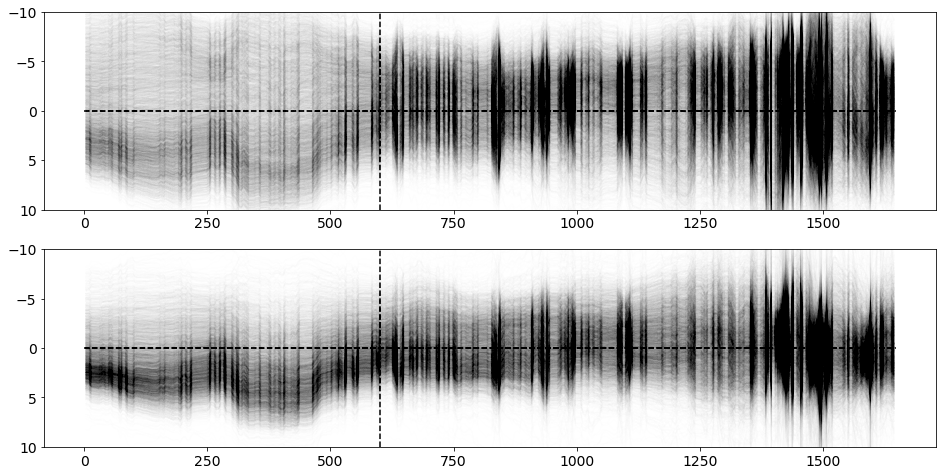

In [91]:
base = '../calcs/along_coast_wind/'
fig, axes = plt.subplots(2,1, figsize=(16,8), sharey=True)
# fig.subplots_adjust(left=0.045, bottom=0.175, right=1.0, top=0.96, wspace=0.02, hspace=0.04)

for i, year in enumerate(years):
    File = base + str(year) + '.npz'
    d = np.load(File)
    # dates are a little messed up in file — forgot to decimate at same rates as other variables.
    # This fixes it.
    dates = d['dates'][::4]
    for j, month in enumerate(months):
        d1 = [pd.Timestamp(dates[i]) >= pd.Timestamp(str(year) + '-' + str(month) + '-1') for i in range(len(dates))]
        d2 = [pd.Timestamp(dates[i]) < pd.Timestamp(str(year) + '-' + str(month+1) + '-1') for i in range(len(dates))]
        tinds = list(set(np.where(d1)[0]).intersection(np.where(d2)[0]))
        walong = np.ma.masked_where(np.isnan(d['walong']), d['walong'])

        if month in [1,2,3]:
            axes[0].plot(d['dist'], walong[tinds,:].T, color='k', alpha=0.005)
#             axes[0].plot(d['dist'], walon[i,j,:], color=cold, alpha=0.25)
        elif month in [7,8,9]:
            axes[1].plot(d['dist'], walong[tinds,:].T, color='k', alpha=0.005)
#             axes[1].plot(d['dist'], walmn[i,j,:], color=cold, alpha=0.25)
axes[0].set_ylim(-10,10)
axes[0].invert_yaxis()
axes[0].hlines(0, d['dist'][0], d['dist'][-1], linestyle='--')
axes[1].hlines(0, d['dist'][0], d['dist'][-1], linestyle='--')

axes[0].vlines(600, 10, -10, linestyle='--')
axes[1].vlines(600, 10, -10, linestyle='--')

In [13]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

latpa, lonpa = 27.834750, -97.047372
latss, lonss = 28.934928, -95.294881

# load in grid
proj = tracpy.tools.make_proj('nwgom-pyproj')
grid = tracpy.inout.readgrid('../../grid.nc', proj)
lon_rho = grid.lon_rho[1:-1,1:-1]
lat_rho = grid.lat_rho[1:-1,1:-1]
x_rho, y_rho = proj(lon_rho, lat_rho)
angle = grid.angle_rho[1:-1,1:-1]  # theta to rotate wind vectors


In [14]:
import shapely.geometry
import tracpy.tools

d = np.load('../../shelf_transport/calcs/coastpaths.npz', encoding='latin1') # use paths in grid space
pathsg = d['pathsg']
pathsxy = d['pathsxy']
outerpathg = d['outerpathg'].item()
d.close()


# convert from grid coords to xy
loncoast, latcoast, _ = tracpy.tools.interpolate2d(outerpathg.vertices[:,0], outerpathg.vertices[:,1], grid, 'm_ij2ll')


# xcoast, ycoast, _ = tracpy.tools.interpolate2d(outerpathg.vertices[:,0], outerpathg.vertices[:,1], grid, 'm_ij2xy')

outerpathll = Path(np.vstack((loncoast,latcoast)).T)
# outerpathx, outerpathy, _ = tracpy.tools.interpolate2d(loncoast, latcoast, grid, 'd_ll2xy')


# distance along the coast boxes
# THIS PROJECTION IS NOT EQUAL DISTANCE
# # code from plot_sampledrifters.py
# dist = np.zeros(len(pathsxy))
# verts0 = pathsxy[0].vertices
# for i, path in enumerate(pathsxy):
#     verts1 = path.vertices
#     dist[i:] += np.sqrt((verts1[0,0]-verts0[0,0])**2+(verts1[0,1]-verts0[0,1])**2)
#     verts0 = verts1.copy()
# dist /= 1000 # convert to km
# dmax = dist.max()
# ae = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=28)

coastll = shapely.geometry.LineString(zip(loncoast, latcoast))
ae = cartopy.crs.AzimuthalEquidistant(central_longitude=-94.5, central_latitude=28.5)
coastxy = ae.project_geometry(coastll, src_crs=pc)

dist = np.zeros(len(pathsg))
lonpath, latpath, _ = tracpy.tools.interpolate2d(pathsg[0].vertices[:,0], pathsg[0].vertices[:,1], grid, 'm_ij2ll')
spathll = shapely.geometry.LinearRing(zip(lonpath,latpath))  # shapely object for path in ll
spathxy = ae.project_geometry(spathll, src_crs=pc)[0][0]  # now in distance-preserving coords
# ae = cartopy.crs.AzimuthalEquidistant(central_longitude=lonpath[0], central_latitude=latpath[0])
cen0 = spathxy.centroid  # centroid in xy of 1st box
for i, path in enumerate(pathsg):
    lonpath, latpath, _ = tracpy.tools.interpolate2d(path.vertices[:,0], path.vertices[:,1], grid, 'm_ij2ll')
#     ae = cartopy.crs.AzimuthalEquidistant(central_longitude=lonpath[0], central_latitude=latpath[0])
    spathll = shapely.geometry.LinearRing(zip(lonpath,latpath))  # shapely object for path in ll
    spathxy = ae.project_geometry(spathll, src_crs=pc)[0][0]  # now in distance-preserving coords
    cen1 = spathxy.centroid
#     print(cen1.distance(cen0)/1000.)
    dist[i:] += cen1.distance(cen0)
#     dist[i:] += np.sqrt((verts1[0,0]-verts0[0,0])**2+(verts1[0,1]-verts0[0,1])**2)
    cen0 = cen1
dist /= 1000 # convert to km
dmax = dist.max()


NameError: name 'Path' is not defined

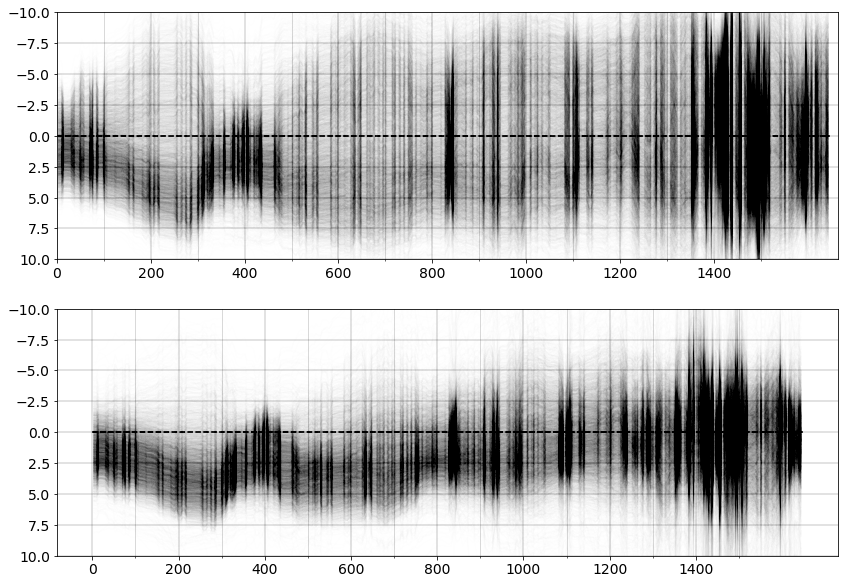

In [8]:
base = '../calcs/along_coast_wind/'
fig, axes = plt.subplots(2,1, figsize=(14,10), sharey=True)
# fig.subplots_adjust(left=0.045, bottom=0.175, right=1.0, top=0.96, wspace=0.02, hspace=0.04)

for i, year in enumerate(years):
    File = base + str(year) + '.npz'
    d = np.load(File)
    # dates are a little messed up in file — forgot to decimate at same rates as other variables.
    # This fixes it.
    dates = d['dates'][::4]
    for j, month in enumerate(months):
        d1 = [pd.Timestamp(dates[i]) >= pd.Timestamp(str(year) + '-' + str(month) + '-1') for i in range(len(dates))]
        d2 = [pd.Timestamp(dates[i]) < pd.Timestamp(str(year) + '-' + str(month+1) + '-1') for i in range(len(dates))]
        tinds = list(set(np.where(d1)[0]).intersection(np.where(d2)[0]))
        walong = np.ma.masked_where(np.isnan(d['wacross']), d['wacross'])

        if month in [1,2,3]:
            axes[0].plot(d['dist'], walong[tinds,:].T, color='k', alpha=0.005)
#             axes[0].plot(d['dist'], walon[i,j,:], color=cold, alpha=0.25)
        elif month in [7,8,9]:
            axes[1].plot(d['dist'], walong[tinds,:].T, color='k', alpha=0.005)
#             axes[1].plot(d['dist'], walmn[i,j,:], color=cold, alpha=0.25)
axes[0].set_ylim(-10,10)
axes[0].invert_yaxis()
axes[0].hlines(0, d['dist'][0], d['dist'][-1], linestyle='--')
axes[1].hlines(0, d['dist'][0], d['dist'][-1], linestyle='--')

# axes[0].vlines(600, 10, -10, linestyle='--')
# axes[1].vlines(600, 10, -10, linestyle='--')

axes[0].set_xlim(dist[0], dist[-1])
axes[0].set_xticks(np.arange(0, 1600, 200))
axes[1].set_xticks(np.arange(0, 1600, 200))
axes[0].set_xticks(np.arange(100, 1600, 200), minor=True)
axes[1].set_xticks(np.arange(100, 1600, 200), minor=True)

axes[0].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[0].grid(which='minor', lw=1.0, color='k', alpha=0.15)
axes[1].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[1].grid(which='minor', lw=1.0, color='k', alpha=0.15)



Object `vline` not found.


## Seasonal Combination with Individual Years

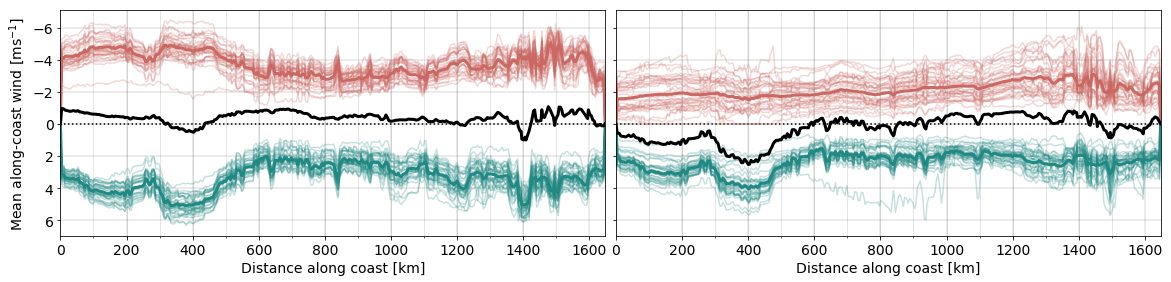

In [252]:
fig, axes = plt.subplots(1,2, figsize=(16,4), sharey=True)
fig.subplots_adjust(left=0.045, bottom=0.175, right=1.0, top=0.96, wspace=0.02, hspace=0.04)

# max
vmax = np.nanmax((abs(walmp), abs(walmn)))

for i, year in enumerate(years):
    for j, month in enumerate(months):
        if month in [1,2,3]:
            axes[0].plot(d['dist'], walmp[i,j,:], color=colu, alpha=0.25)
            axes[0].plot(d['dist'], walmn[i,j,:], color=cold, alpha=0.25)
        elif month in [7,8,9]:
            axes[1].plot(d['dist'], walmp[i,j,:], color=colu, alpha=0.25)
            axes[1].plot(d['dist'], walmn[i,j,:], color=cold, alpha=0.25)


# mean positive and mean negative            
axes[0].plot(d['dist'], (walmp[:,[0,1,1,2],:]).mean(axis=0).mean(axis=0), color=colu, lw=3)
axes[0].plot(d['dist'], (walmn[:,[0,1,1,2],:]).mean(axis=0).mean(axis=0), color=cold, lw=3)
axes[1].plot(d['dist'], (walmp[:,[6,7,7,8],:]).mean(axis=0).mean(axis=0), color=colu, lw=3)
axes[1].plot(d['dist'], (walmn[:,[6,7,7,8],:]).mean(axis=0).mean(axis=0), color=cold, lw=3)
            
# mean overall
axes[0].plot(d['dist'], (walmp[:,[0,1,1,2],:] + walmn[:,[0,1,1,2],:]).mean(axis=0).mean(axis=0), color='k', lw=3)
axes[1].plot(d['dist'], (walmp[:,[6,7,7,8],:] + walmn[:,[6,7,7,8],:]).mean(axis=0).mean(axis=0), color='k', lw=3)

for ax in axes:
#     ax.set_ylim(-vmax, vmax)
    ax.set_xlim(0, d['dist'][-1])
    ax.hlines(0, d['dist'][0], d['dist'][-1], linestyle=':')

    ax.set_xticks(np.arange(100, 1600, 100), minor=True)
    ax.grid(which='major', lw=1.5, color='k', alpha=0.1)
    ax.grid(which='minor', lw=1, color='k', alpha=0.1)
    

    ax.set_xlabel('Distance along coast [km]')
    
axes[0].set_ylabel('Mean along-coast wind [ms$^{-1}$]')
axes[0].invert_yaxis()

## Seasonal Mean

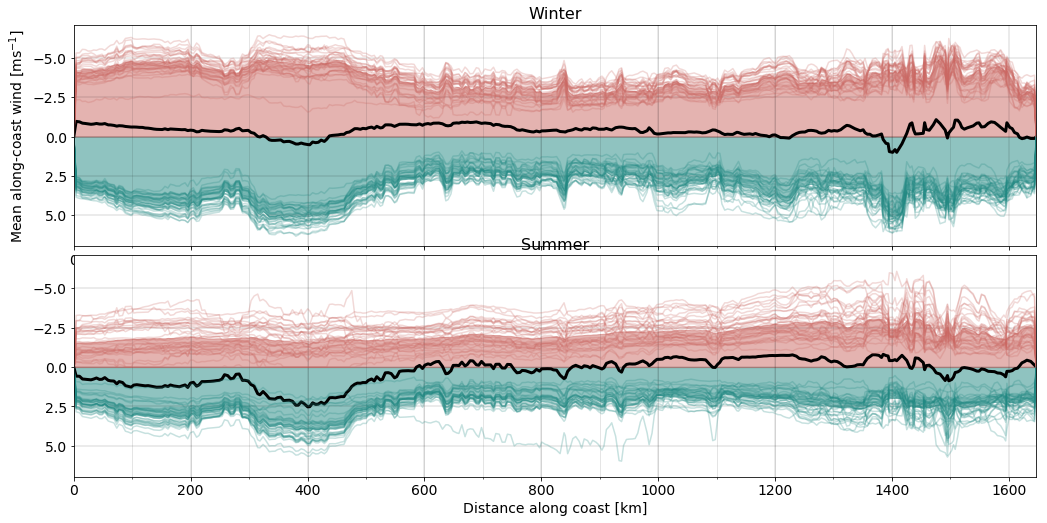

In [251]:
fig, axes = plt.subplots(2,1, figsize=(14, 8), sharey=True)
fig.subplots_adjust(left=0.045, bottom=0.175, right=1.0, top=0.96, wspace=0.02, hspace=0.04)

# max
# vmax = np.nanmax((abs(walmp), abs(walmn)))

# mean positive and mean negative            
# winter
axes[0].fill_between(d['dist'], (walmp[:,[0,1,1,2],:]).mean(axis=0).mean(axis=0), color=colu, alpha=0.5)
axes[0].fill_between(d['dist'], (walmn[:,[0,1,1,2],:]).mean(axis=0).mean(axis=0), color=cold, alpha=0.5)
axes[0].set_title('Winter', fontsize=16)
# summer
axes[1].fill_between(d['dist'], (walmp[:,[6,7,7,8],:]).mean(axis=0).mean(axis=0), color=colu, alpha=0.5)
axes[1].fill_between(d['dist'], (walmn[:,[6,7,7,8],:]).mean(axis=0).mean(axis=0), color=cold, alpha=0.5)
axes[1].set_title('Summer', fontsize=16)
            
# mean overall
axes[0].plot(d['dist'], (walmp[:,[0,1,1,2],:] + walmn[:,[0,1,1,2],:]).mean(axis=0).mean(axis=0), color='k', lw=3)
axes[1].plot(d['dist'], (walmp[:,[6,7,7,8],:] + walmn[:,[6,7,7,8],:]).mean(axis=0).mean(axis=0), color='k', lw=3)


for i, year in enumerate(years):
    for j, month in enumerate(months):
        if month in [1,2,3]:
            axes[0].plot(d['dist'], walmp[i,j,:], color=colu, alpha=0.25)
            axes[0].plot(d['dist'], walmn[i,j,:], color=cold, alpha=0.25)
        elif month in [7,8,9]:
            axes[1].plot(d['dist'], walmp[i,j,:], color=colu, alpha=0.25)
            axes[1].plot(d['dist'], walmn[i,j,:], color=cold, alpha=0.25)

            
for ax in axes:
#     ax.set_ylim(-vmax, vmax)
    ax.set_xlim(0, d['dist'][-1])

    ax.set_xticks(np.arange(100, 1600, 100), minor=True)
    ax.grid(which='major', lw=1.5, color='k', alpha=0.1)
    ax.grid(which='minor', lw=1, color='k', alpha=0.1)

    ax.set_xlabel('Distance along coast [km]')
    
axes[0].invert_yaxis()
axes[0].set_ylabel('Mean along-coast wind [ms$^{-1}$]')


## Winter Interannual Mean



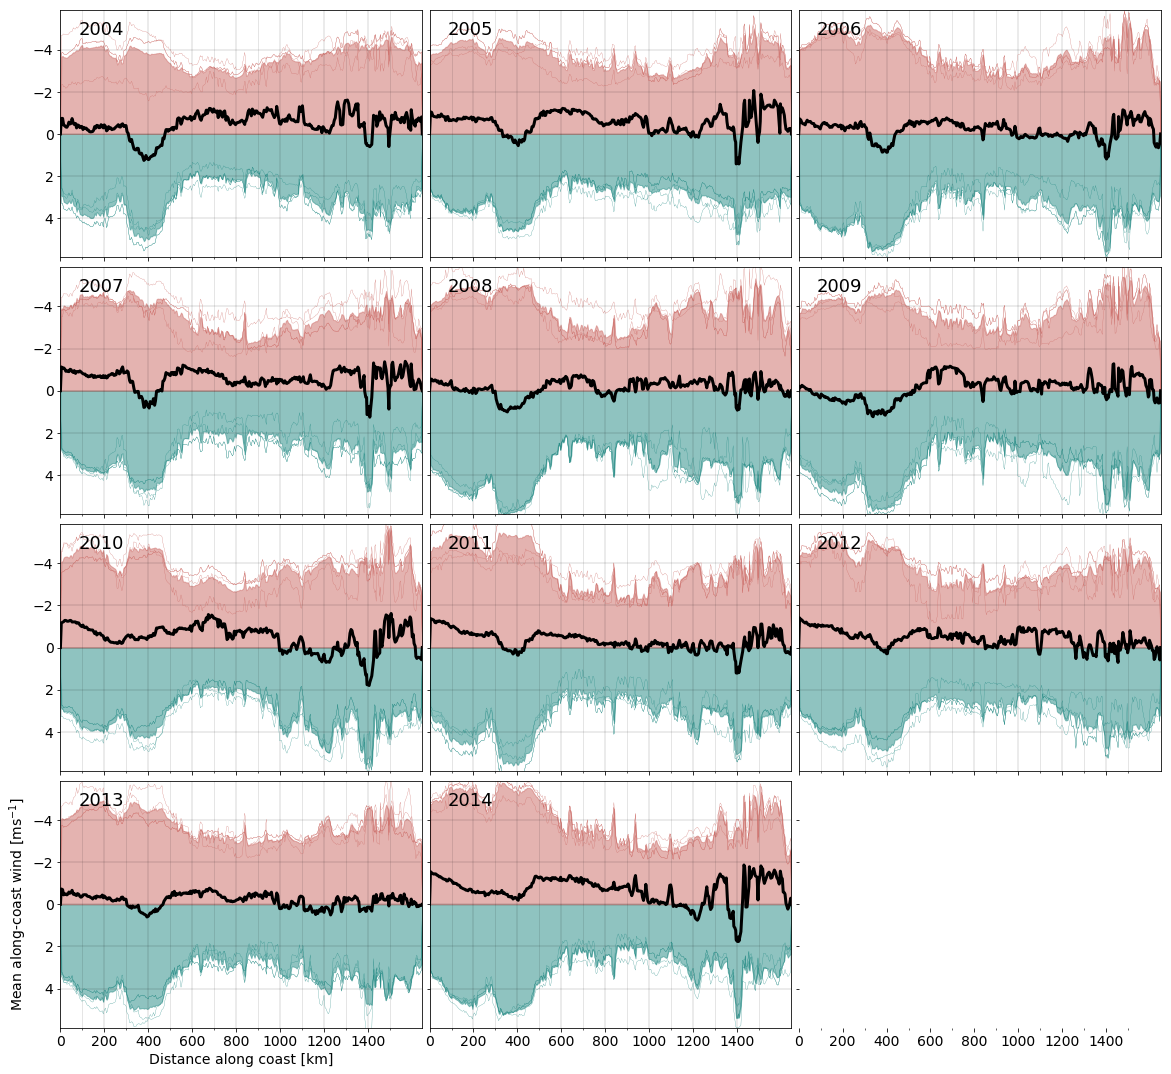

In [247]:
fig, axes = plt.subplots(4,3, figsize=(16, 18), sharey=True, sharex=True)
fig.subplots_adjust(left=0.045, bottom=0.175, right=1.0, top=0.96, wspace=0.02, hspace=0.04)

# max
vmax = np.nanmax((abs(walmp[:,[0,1,1,2],:].mean(axis=1)), abs(walmn[:,[0,1,1,2],:].mean(axis=1))))

for i, ax in enumerate(axes.flatten()):

    if i != 11:
        
        
        ax.fill_between(d['dist'], (walmp[i,[0,1,1,2],:]).mean(axis=0), color=colu, alpha=0.5)
        ax.fill_between(d['dist'], (walmn[i,[0,1,1,2],:]).mean(axis=0), color=cold, alpha=0.5)

        ax.text(0.05, 0.9, str(years[i]), transform=ax.transAxes, fontsize=18)
    
        # add lines for months
        ax.plot(d['dist'], walmp[i,[0,1,1,2],:].T, color=colu, alpha=1, lw=0.25)
        ax.plot(d['dist'], walmn[i,[0,1,1,2],:].T, color=cold, alpha=1, lw=0.25)

        # mean overall for year/season combo
        ax.plot(d['dist'], (walmp[i,[0,1,1,2],:] + walmn[i,[0,1,1,2],:]).mean(axis=0), color='k', lw=3)

        
for i, ax in enumerate(axes.flatten()):
    if i != 11:
        ax.set_ylim(-vmax, vmax)
        ax.set_xlim(0, d['dist'][-1])
        ax.set_xticks(np.arange(100, 1600, 200), minor=True)
        ax.set_xticks(np.arange(0, 1600, 200), minor=False)
        ax.grid(which='major', lw=1.5, color='k', alpha=0.1)
        ax.grid(which='minor', lw=1, color='k', alpha=0.1)
        ax.invert_yaxis()

        if i in [9]:
            ax.set_xlabel('Distance along coast [km]')

        if i in [9]:
            ax.set_ylabel('Mean along-coast wind [ms$^{-1}$]')
    else:
        ax.set_frame_on(False)



## Summer Interannual Mean

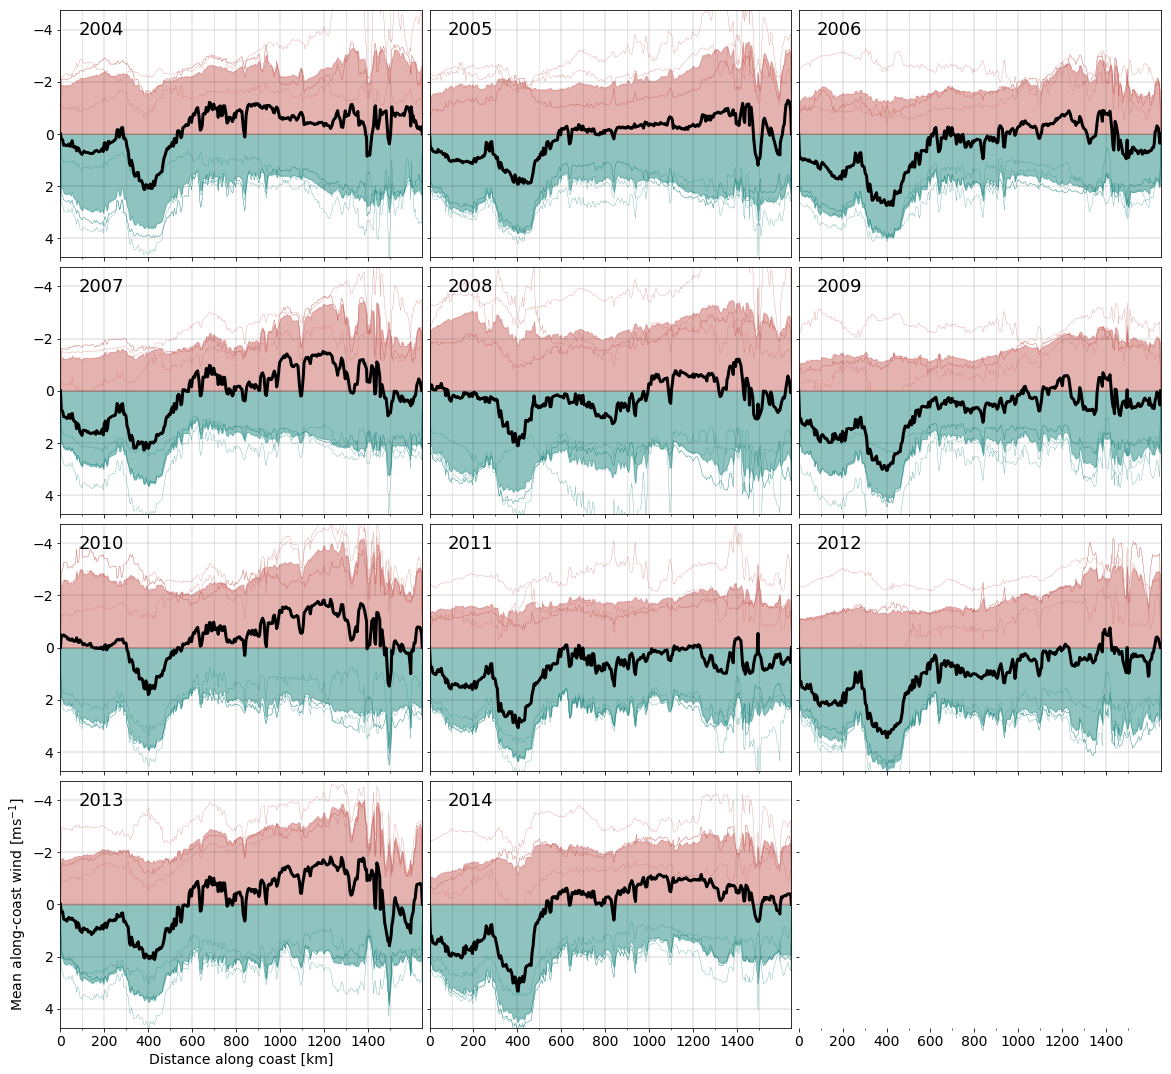

In [248]:
fig, axes = plt.subplots(4,3, figsize=(16, 18), sharey=True, sharex=True)
fig.subplots_adjust(left=0.045, bottom=0.175, right=1.0, top=0.96, wspace=0.02, hspace=0.04)

# max
vmax = np.nanmax((abs(walmp[:,[6,7,7,8],:].mean(axis=1)), abs(walmn[:,[6,7,7,8],:].mean(axis=1))))

for i, ax in enumerate(axes.flatten()):

    if i != 11:
        
        
        ax.fill_between(d['dist'], (walmp[i,[6,7,7,8],:]).mean(axis=0), color=colu, alpha=0.5)
        ax.fill_between(d['dist'], (walmn[i,[6,7,7,8],:]).mean(axis=0), color=cold, alpha=0.5)

        ax.text(0.05, 0.9, str(years[i]), transform=ax.transAxes, fontsize=18)
    
        # add lines for months
        ax.plot(d['dist'], walmp[i,[6,7,7,8],:].T, color=colu, alpha=1, lw=0.25)
        ax.plot(d['dist'], walmn[i,[6,7,7,8],:].T, color=cold, alpha=1, lw=0.25)

        # mean overall for year/season combo
        ax.plot(d['dist'], (walmp[i,[6,7,7,8],:] + walmn[i,[6,7,7,8],:]).mean(axis=0), color='k', lw=3)

        
for i, ax in enumerate(axes.flatten()):
    if i != 11:
        ax.set_ylim(-vmax, vmax)
        ax.set_xlim(0, d['dist'][-1])
        ax.set_xticks(np.arange(100, 1600, 200), minor=True)
        ax.set_xticks(np.arange(0, 1600, 200), minor=False)
        ax.grid(which='major', lw=1.5, color='k', alpha=0.1)
        ax.grid(which='minor', lw=1, color='k', alpha=0.1)
        ax.invert_yaxis()

        if i in [9]:
            ax.set_xlabel('Distance along coast [km]')

        if i in [9]:
            ax.set_ylabel('Mean along-coast wind [ms$^{-1}$]')
    else:
        ax.set_frame_on(False)



## Can I use results to predict movement between bays?

Draw bay start and stop locations on these plots and how far they can go between with a line.

## Under what (wind, river) conditions can drifters move between Port Aransas and Surfside?

# drifters leaving the alongcoast region

Plot drifters coming from box or boxes downcoast from 600km alongcoast distance and see if their tracks leave the alongcoast region due to the coastline bump.

In [44]:
mat = np.load('../calcs/alongcoastconn/2007-08-01T00.npz')
mat.keys()
iinside = mat['iinside']

In [45]:
iinside.shape

(94443,)

In [6]:
mat['outbox'].shape

(342, 94443, 5)

In [131]:
ind = np.where(~np.isnan(mat['outbox'][110,:,0]))[0]

match drifters up that exit box 120

In [8]:
import netCDF4 as netCDF
d = netCDF.Dataset('../tracks/2007-08-01T00gc.nc')
xg = d['xg'][:]; yg = d['yg'][:]


/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
xg2 = xg[iinside[ind],:]; yg2 = yg[iinside[ind],:]

In [133]:
import tracpy.tools
# load in grid
proj = tracpy.tools.make_proj('nwgom-pyproj')
grid = tracpy.inout.readgrid('../../grid.nc', proj)

lonp, latp, _ = tracpy.tools.interpolate2d(xg2, yg2, grid, 'm_ij2ll')

In [6]:
d = np.load('../../shelf_transport/calcs/coastpaths.npz', encoding='latin1') # use paths in grid space
pathsg = d['pathsg']
pathsxy = d['pathsxy']
outerpathg = d['outerpathg'].item()
d.close()

# distance along the coast boxes
# code from plot_sampledrifters.py
dist = np.zeros(len(pathsxy))
verts0 = pathsxy[0].vertices
for i, path in enumerate(pathsxy):
    verts1 = path.vertices
    dist[i:] += np.sqrt((verts1[0,0]-verts0[0,0])**2+(verts1[0,1]-verts0[0,1])**2)
    verts0 = verts1.copy()
dist /= 1000 # convert to km
dmax = dist.max()


In [134]:
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator()
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
from matplotlib.path import Path
import matplotlib.patches as Patches


patches = []
# for i, path in enumerate(pathsg[125]):
i=110; path=pathsg[i]
pathslon, pathslat, _ = tracpy.tools.interpolate2d(path.vertices[:,0], path.vertices[:,1], grid, 'm_ij2ll')
p = Path(np.vstack((pathslon,pathslat)).T)
# ax.add_patch(Patches.PathPatch(p, facecolor='yellow', transform=pc, zorder=10))
#     if np.mod(i, 10) == 0:
# ax.text(pathslon[0] + 0.25, pathslat[0], str(i), fontsize=15, color='g', transform=pc)

for j in range(lonp[:,::10].shape[1]):

    fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))
    ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
    ax.set_frame_on(False) # kind of like it without the box
    ax.set_extent([-97.5, -95.4, 27.4, 28.8], pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    # the following two make the labels look like lat/lon format
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_bottom = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    ax.add_feature(land_10m, facecolor='0.8')
    ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'
    ax.add_patch(Patches.PathPatch(p, facecolor='yellow', transform=pc, zorder=10))


    plt.plot(lonp[::20,j*10].T, latp[::20,j*10].T, 'ko', transform=pc);

    fig.savefig('../figures/alongcoastconn/example_coastline_impact/' + str(j) + '.png', bbox_inches='tight')
    plt.close(fig)

In [76]:
np.where(dist <= 596)[-1]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

In [79]:
dist[121]

601.28802175216549

In [129]:
j

319

In [81]:
len(pathsg)

342